In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch.nn import Linear, ReLU, LeakyReLU, ELU
from torch_geometric.nn import Sequential, GCNConv, GATConv
import numpy as np
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
import seaborn as sns
import pandas as pd
from typing import Union
from tqdm import tqdm
import os

torch.cuda.is_available()

False

In [5]:
dataset = Planetoid(root="../../data/cora",name= "Cora")

# Creating a baseline

In [6]:
# Get the X and y data
X_data = dataset.data.x
y_data = dataset.data.y

/home/rick/Documents/ai-codex-public-code/.venv/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
# Count the number of samples per class
unique, counts = np.unique(y_data, return_counts=True)
for i in range(len(unique)):
    print("Class: {} - Samples: {}".format(unique[i], counts[i]))

Class: 0 - Samples: 351
Class: 1 - Samples: 217
Class: 2 - Samples: 418
Class: 3 - Samples: 818
Class: 4 - Samples: 426
Class: 5 - Samples: 298
Class: 6 - Samples: 180


## Train a baseline model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [9]:
## Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

## Test the model
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.757754800590842

## Train the models

In [10]:
## Compare them using 10-fold cross-validation
models = [
{
    "model": MultinomialNB(),
    "name": "MultinomialNB"
}, 
{
    "model": BernoulliNB(),
    "name": "BernoulliNB"
}, 
{
    "model": LogisticRegression(),
    "name": "LogisticRegression"
},
{
    "model": MLPClassifier(hidden_layer_sizes=(64, 32), activation="relu", solver="adam"),
    "name": "Deep FF"
},
{
    "model": MLPClassifier(hidden_layer_sizes=(64, ), activation="relu", solver="adam"),
    "name": "Shallow FF"
}]

# Format: [{model_name, str, accuracy: float}]
results = []

# Cross validate
for model in models:
    # The current model
    print(f'current model: {model["name"]}')
    # perform cross-validation
    scores = cross_val_score(
        model["model"], 
        X_data, y_data, 
        cv=StratifiedKFold(10, shuffle=True, random_state=42), 
        n_jobs=-1,
        scoring="accuracy",
        )
    # Append the results
    for score in scores:
        results.append({
            "model": model["name"],
            "accuracy": score
        })


current model: MultinomialNB
current model: BernoulliNB
current model: LogisticRegression
current model: Deep FF
current model: Shallow FF


Text(0.5, 1.0, 'Comparison of different models')

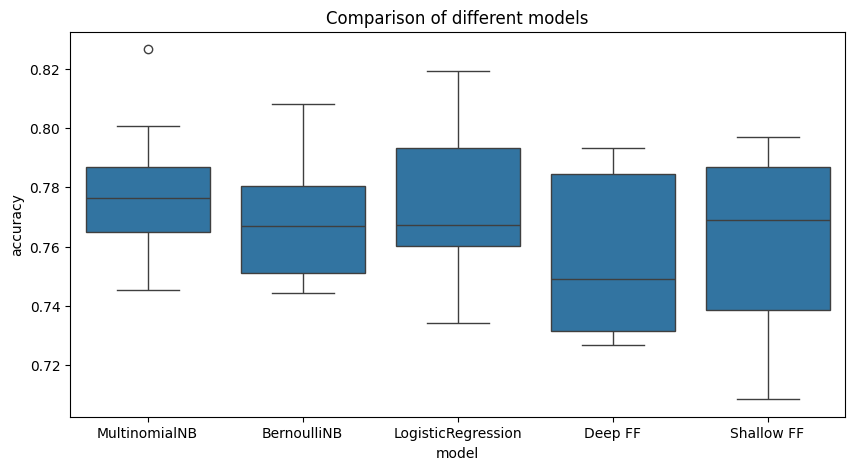

In [11]:
# Plot using seaborn
df = pd.DataFrame(results)
plt.figure(figsize=(10, 5))
sns.boxplot(x="model", y="accuracy", data=df)
plt.title("Comparison of different models")

## Train GNN

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
def shuffle_data(dataset, train_size=140, val_size=500):
    train_mask, test_mask = train_test_split(range(2708), train_size=train_size + val_size, stratify=dataset.data.y.numpy())
    train_mask, val_mask = train_test_split(train_mask, train_size=train_size, stratify=dataset.data.y.numpy()[train_mask])

    dataset.data.train_mask = torch.zeros(dataset.data.num_nodes, dtype=torch.uint8)
    dataset.data.train_mask[train_mask] = 1

    dataset.data.val_mask = torch.zeros(dataset.data.num_nodes, dtype=torch.uint8)
    dataset.data.val_mask[val_mask] = 1

    dataset.data.test_mask = torch.zeros(dataset.data.num_nodes, dtype=torch.uint8)
    dataset.data.test_mask[test_mask] = 1

    dataset.data.x = dataset.data.x.to(device)
    dataset.data.y = dataset.data.y.to(device)
    dataset.data.edge_index = dataset.data.edge_index.to(device)
    dataset.data.train_mask = dataset.data.train_mask.to(device)
    dataset.data.val_mask = dataset.data.val_mask.to(device)
    dataset.data.test_mask = dataset.data.test_mask.to(device)

shuffle_data(dataset, train_size=140, val_size=500)

/home/rick/Documents/ai-codex-public-code/.venv/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/rick/Documents/ai-codex-public-code/.venv/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg

In [23]:
class GAT(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=8, heads=8, dropout=0.3, activation=ELU):
        super(GAT, self).__init__()
        if type(dropout) == float:
            dropout = [dropout]*2
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout[0])
        self.conv2 = GATConv(hidden_dim*heads, output_dim, concat=False, heads=1, dropout=dropout[1])
        self.activation = activation(inplace=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x, e = self.conv2(x, edge_index, return_attention_weights=True)
        return x, e
    
def train_gnn(model, dataset, criterion, optimizer, epochs=100, return_best_weights=True, patients:Union[int, None]=5, model_weights_path='../../weights/cora/best_model_gnn.pt'):

    # Create folder if doesn't exist
    os.makedirs(os.path.dirname(model_weights_path), exist_ok=True)

    running_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_epoch = 0

    # Train model
    for epoch in tqdm(range(epochs)):
        # Training step
        # Put the model in training mode
        model.train()
        # Reset the gradients
        optimizer.zero_grad()
        # Forward pass
        out, _ = model(dataset.data.x, dataset.data.edge_index)
        # Only calculate the loss on the training nodes
        loss = criterion(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()

        running_loss = loss.item()
        running_losses.append(running_loss)

        # Validation step
        model.eval()

        with torch.no_grad():
            out, _ = model(dataset.data.x, dataset.data.edge_index)
            val_loss = criterion(out[dataset.data.val_mask], dataset.data.y[dataset.data.val_mask])
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct = pred[dataset.data.val_mask] == dataset.data.y[dataset.data.val_mask]  # Check against ground-truth labels.
            val_accuracy = int(correct.sum()) / int(dataset.data.val_mask.sum())  # Derive ratio of correct predictions.

            val_losses.append(val_loss.detach().cpu().item())
            val_accuracies.append(val_accuracy)

        # Save model if validation loss has decreased
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), model_weights_path)

        # Stop if model stopped improving after patients
        if patients != None and epoch - best_epoch > patients:
            break

    if return_best_weights:
        model.load_state_dict(torch.load(model_weights_path, weights_only=True))

    return model, running_losses, val_losses, val_accuracies

def test_gnn(model, dataset, criterion):
    model.eval()
    # test model
    with torch.no_grad():
        out, _ = model(dataset.data.x, dataset.data.edge_index)
        test_loss = criterion(out[dataset.data.test_mask], dataset.data.y[dataset.data.test_mask])
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]  # Check against ground-truth labels.
        test_accuracy = int(correct.sum()) / int(dataset.data.test_mask.sum())  # Derive ratio of correct predictions.

    return test_loss.detach().cpu().item(), test_accuracy

In [24]:


class FF(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32, activation=ReLU, dropout=0.3):
        super(FF, self).__init__()
        if type(dropout) == float:
            dropout = [dropout]*2
        self.fc1 = Linear(input_dim, hidden_dim)
        self.fc2 = Linear(hidden_dim, output_dim)
        self.activation = activation(inplace=True)
        self.dropout = dropout

    def forward(self, x):
        x = self.fc1(x)
        # add dropout
        x = F.dropout(x, p=self.dropout[0], training=self.training)
        x = self.activation(x)
        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout[1], training=self.training)
        return x

def train_ff(model, dataset, criterion, optimizer, epochs=100, return_best_weights=True, patients:Union[int, None]=5, model_weights_path='../../weights/cora/best_model_gnn.pt'):

    # Create folder if doesn't exist
    os.makedirs(os.path.dirname(model_weights_path), exist_ok=True)

    running_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_epoch = 0

    # Train model
    for epoch in tqdm(range(epochs)):
        # Training step
        # Put the model in training mode
        model.train()
        # Reset the gradients
        optimizer.zero_grad()
        # Forward pass 
        out = model(dataset.data.x[dataset.data.train_mask])
        # Only calculate the loss on the training nodes
        loss = criterion(out, dataset.data.y[dataset.data.train_mask])
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()

        running_loss = loss.item()
        running_losses.append(running_loss)

        # Validation step
        model.eval()

        with torch.no_grad():
            out = model(dataset.data.x[dataset.data.val_mask])
            val_loss = criterion(out, dataset.data.y[dataset.data.val_mask])
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct = pred== dataset.data.y[dataset.data.val_mask]  # Check against ground-truth labels.
            val_accuracy = int(correct.sum()) / int(dataset.data.val_mask.sum())  # Derive ratio of correct predictions.

            val_losses.append(val_loss.detach().cpu().item())
            val_accuracies.append(val_accuracy)

        # Save model if validation loss has decreased
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), model_weights_path)

        # Stop if model stopped improving after patients
        if patients != None and epoch - best_epoch > patients:
            break

    if return_best_weights:
        model.load_state_dict(torch.load(model_weights_path, weights_only=True))

    return model, running_losses, val_losses, val_accuracies

def test_ff(model, dataset, criterion):
    model.eval()
    # test model
    with torch.no_grad():
        out = model(dataset.data.x[dataset.data.test_mask])
        test_loss = criterion(out, dataset.data.y[dataset.data.test_mask])
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct = pred == dataset.data.y[dataset.data.test_mask]  # Check against ground-truth labels.
        test_accuracy = int(correct.sum()) / int(dataset.data.test_mask.sum())  # Derive ratio of correct predictions.

    return test_loss.detach().cpu().item(), test_accuracy

### Train single GAT model on dataset

In [25]:

gat = GAT(dataset.num_features, dataset.num_classes, 
          hidden_dim=16, heads=12, dropout=0.3).to(device)

optimizer = optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

gat, running_losses, val_losses, val_accuracies = train_gnn(gat, dataset, criterion, optimizer, 
                                                            epochs=1000, 
                                                            return_best_weights=True, 
                                                            patients=5)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/rick/Documents/ai-codex-public-code/.venv/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/tmp/ipykernel_21178/339971205.py:38: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
/home/rick/Documents/ai-codex-public-code/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: indexing with dtype torch.uint8 is now 

Min val_loss: 0.6420657634735107


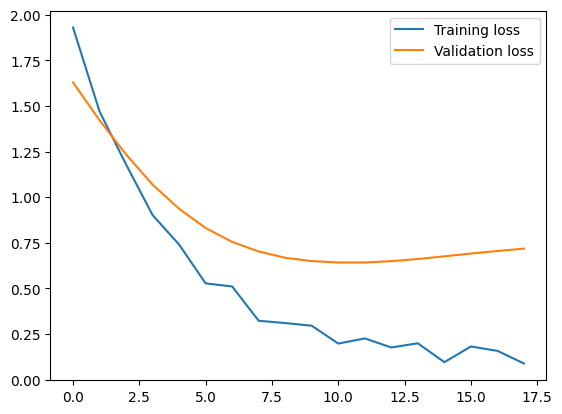

Finished Training


In [26]:
# Plot the losses
print(f"Min val_loss: {min(val_losses)}")
plt.plot(running_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()
print('Finished Training')

0.806


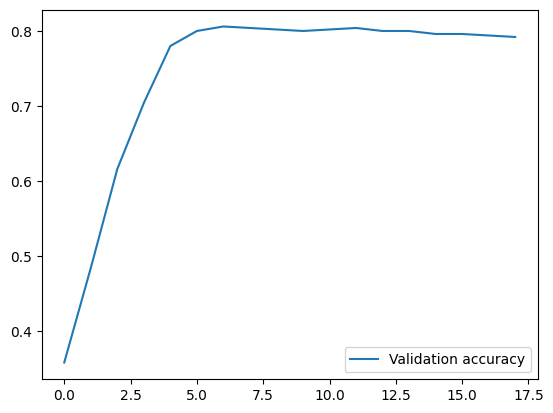

In [27]:
# Plot the accuracies
plt.plot(val_accuracies, label='Validation accuracy')
print(max(val_accuracies))
plt.legend()
plt.show()

In [29]:
test_gnn(gat, dataset, criterion)

/home/rick/Documents/ai-codex-public-code/.venv/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/tmp/ipykernel_21178/339971205.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  test_loss = criterion(out[dataset.data.test_mask], dataset.data.y[dataset.data.test_mask])
/tmp/ipykernel_21178/339971205.py:82: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/Index

(0.5957294702529907, 0.8051257253384912)

### Train single FF on data

In [32]:
ff = FF(dataset.num_features, dataset.num_classes, 
          hidden_dim=64, dropout=0.3).to(device)

optimizer = optim.Adam(ff.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

ff, running_losses, val_losses, val_accuracies = train_ff(ff, dataset, criterion, optimizer, 
                                                          epochs=1000, 
                                                          return_best_weights=True, 
                                                          patients=5)

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_21178/2956529926.py:40: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  out = model(dataset.data.x[dataset.data.train_mask])
/tmp/ipykernel_21178/2956529926.py:42: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(out, dataset.data.y[dataset.data.train_mask])
/tmp/ipykernel_21178/2956529926.py:55: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  out = model(dataset.data.x[dataset.data.val_mask])
/tmp/ipykernel_21178/2956529926.py:56: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggere

In [34]:
test_ff(ff, dataset, criterion)

/tmp/ipykernel_21178/2956529926.py:83: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  out = model(dataset.data.x[dataset.data.test_mask])
/tmp/ipykernel_21178/2956529926.py:84: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  test_loss = criterion(out, dataset.data.y[dataset.data.test_mask])
/tmp/ipykernel_21178/2956529926.py:86: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  correct = pred == dataset.data.y[dataset.data.test_mask]  # Check against ground-truth labels.


(1.1894086599349976, 0.5831721470019342)

### Quantitative testing

In [37]:
shuffle_data(dataset, train_size=140, val_size=500)
results = []
for i in range(10):
    
    print(i)

    # Train GAT model
    gat = GAT(dataset.num_features, dataset.num_classes, 
            hidden_dim=16, heads=12, dropout=0.3).to(device)

    optimizer = optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    gat, running_losses, val_losses, val_accuracies = train_gnn(gat, dataset, criterion, optimizer, 
                                                                  epochs=30, 
                                                                  return_best_weights=True, 
                                                                  patients=None)
    
    _, test_accuracies = test_gnn(gat, dataset, criterion)

    results.append({'model': 'GAT', 'accuracy': test_accuracies, 'split': i})

    # Train FF model
    ff = FF(dataset.num_features, dataset.num_classes, 
            hidden_dim=64, dropout=0.3).to(device)

    optimizer = optim.Adam(ff.parameters(), lr=0.005, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    ff, running_losses, val_losses, val_accuracies = train_ff(ff, dataset, criterion, optimizer, 
                                                                  epochs=30, 
                                                                  return_best_weights=True, 
                                                                  patients=None)
    
    _, test_accuracies = test_ff(ff, dataset, criterion)

    results.append({'model': 'Deep FF 2', 'accuracy': test_accuracies, 'split': i})

    

/home/rick/Documents/ai-codex-public-code/.venv/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/rick/Documents/ai-codex-public-code/.venv/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg

0


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_21178/339971205.py:38: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
/home/rick/Documents/ai-codex-public-code/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipykernel_21178/339971205.py:52: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  val_loss = criterion(out[dataset.data.val_mask], dataset.data.y[d

1


100%|██████████| 30/30 [00:00<00:00, 403.30it/s]


2


100%|██████████| 30/30 [00:00<00:00, 401.46it/s]


3


100%|██████████| 30/30 [00:00<00:00, 415.20it/s]


4


100%|██████████| 30/30 [00:00<00:00, 386.67it/s]


5


100%|██████████| 30/30 [00:00<00:00, 373.08it/s]


6


100%|██████████| 30/30 [00:00<00:00, 390.19it/s]


7


100%|██████████| 30/30 [00:00<00:00, 371.17it/s]


8


100%|██████████| 30/30 [00:00<00:00, 370.18it/s]


9


100%|██████████| 30/30 [00:00<00:00, 433.41it/s]


<Axes: xlabel='model', ylabel='accuracy'>

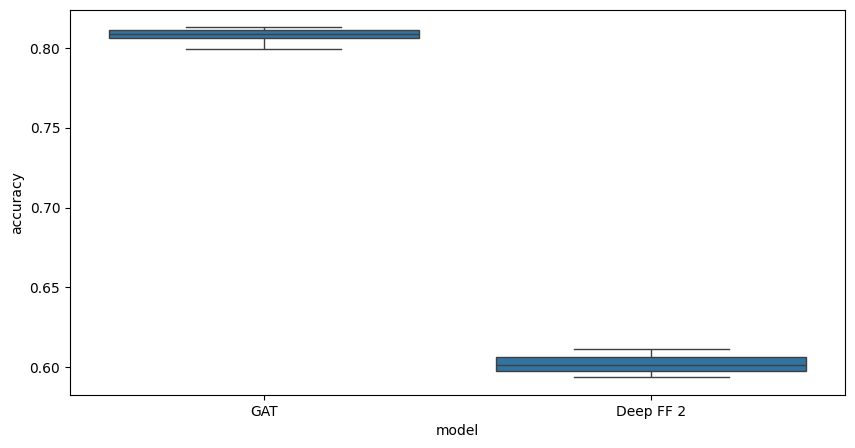

In [38]:
# plot boxplot with sns
plt.figure(figsize=(10, 5))
df = pd.DataFrame(results)
sns.boxplot(x='model', y='accuracy', data=df)